In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)


In [11]:
#this file contains judges attributes and their ideology
#negative ideology score = liberal, positive ideology score = conservative
#zero is the approximately the median/centrist score
judges = pd.read_csv("Judge Attribute and Ideology.csv")

#ideology data are not consistent before 1956
judges = judges[judges["Year of Appointment"] > 1956]


#rescaling the ideology variable for presentation
judges["Ideology Score"] = 100*judges["Ideology Score"]

#the absolute value of the ideology score measures a judge's distance from the ideological centre
judges["Absolute Ideology"] = abs(judges["Ideology Score"])

#the dataset includes attributes of judges including:
#gender, race, age, politican party, past experience (including in politics)
judges.head()

,Name,Circuit,ID,Appointing President,Appointing President Party,Year of Departure,Year of Birth,Year of Death,President when Departed,Reason for Departing,...,Previous Position - ccoun,Previous Position - ccom,Previous Position - ada,Previous Position - da,Previous Position - lother,Previous Position - lotherl,Previous Position - lawprof,Previous Position - private,Ideology Score,Absolute Ideology
2,"Acker, William Marsh, Jr.",11,10,Reagan,Republican,1996,1927.0,9999.0,Clinton,Retired,...,0,0,0,0,0,0,0,1,40.700001,40.700001
3,"Ackerman, Harold Arnold",3,15,Carter,Democrat,1994,1928.0,9999.0,Clinton,Retired,...,0,0,0,0,0,0,0,1,-30.599999,30.599999
4,"Ackerman, James Waldo",7,20,Ford,Republican,1984,1926.0,1984.0,Reagan,Died,...,0,0,0,0,1,1,0,1,6.100000,6.100000
5,"Acosta, Raymond L.",1,25,Reagan,Republican,1994,1925.0,9999.0,Clinton,Retired,...,0,0,0,0,0,0,0,1,53.799999,53.799999
8,"Adams, John R.",6,30323,"Bush, 43",Republican,9999,1955.0,9999.0,Active Ser.,Active Service,...,0,0,0,0,0,0,0,0,16.850001,16.850001


In [12]:
#to provide motivation for our analysis, we will create a graph
#showing how the average ideology of judges shifts over time 

year_ideology = judges.groupby("Year of Appointment")[["Absolute Ideology","Ideology Score"]].mean()
year_ideology.reset_index(inplace = True)


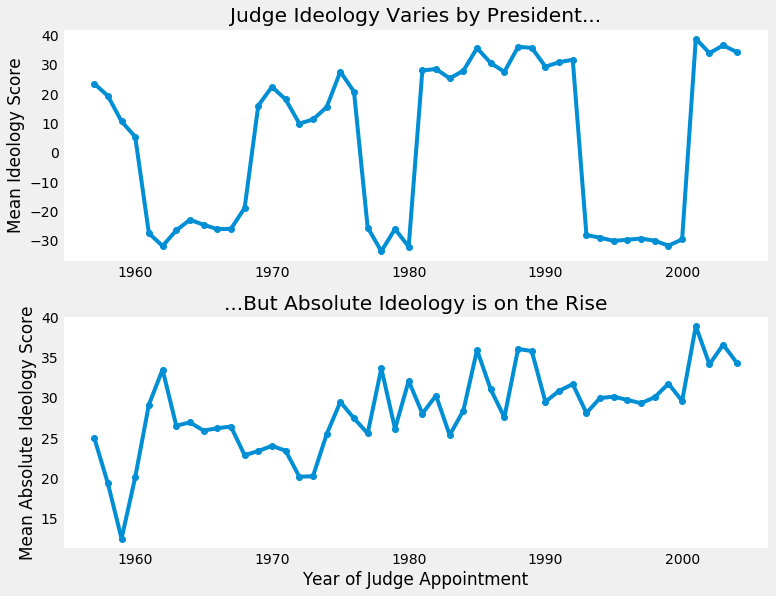

In [13]:
plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(2,1,figsize=(11,8.5))

# Hide grid lines, set a white face color, and set yaxis label
for counter, value in enumerate(["Mean Ideology Score","Mean Absolute Ideology Score"]):
    ax[counter].set_facecolor('white')
    ax[counter].grid(False)
    ax[counter].set_ylabel(value)
    
for counter, value in enumerate(["Ideology Score","Absolute Ideology"]):
    ax[counter].plot(year_ideology["Year of Appointment"],
                    year_ideology[value],"-o")
      
ax[0].set_title("Judge Ideology Varies by President...")   
ax[1].set_title("...But Absolute Ideology is on the Rise")

ax[1].set_xlabel("Year of Judge Appointment")


#fig.text(.2, 0.03, "*Mean Score of Judges ", ha='center',fontsize=14)


fig.tight_layout()


In [14]:
#the graph above showed judges have become more ideological.
#our next question is whether this trend occurred in Democratic judges,  Republican judges, or both?

#since ideology varies so much based on the president in power, we'll look at the judge's year of birth,
#rather than year of appointment to see whether newer judges are more ideoligical than older ones

age_ideology = judges.groupby(["Year of Birth","Judge Party"])[["Ideology Score","Absolute Ideology"]].mean()
age_ideology.reset_index(inplace = True)


Text(0, 0.5, 'Mean Ideology Score')

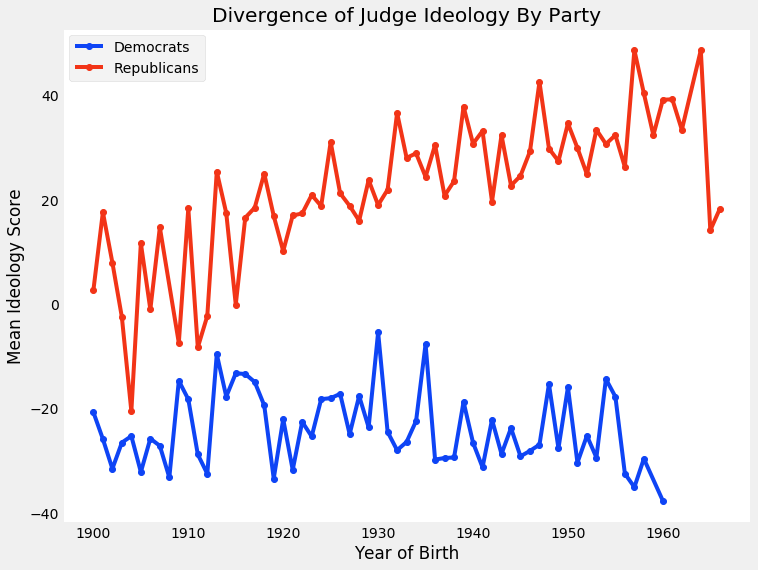

In [15]:
fig, ax = plt.subplots(figsize=(11,8.5))

ax.set_facecolor('white')
ax.grid(False)


initial_age = 1900

recent = age_ideology["Year of Birth"] >= initial_age

democrats = age_ideology["Judge Party"] == "Democrat"
republicans = age_ideology["Judge Party"] == "Republican"

ax.plot(age_ideology[democrats & recent]["Year of Birth"],
        age_ideology[democrats & recent]["Ideology Score"],"-o",label="Democrats",color="#0e44f5")

ax.plot(age_ideology[republicans & recent]["Year of Birth"],
        age_ideology[republicans & recent]["Ideology Score"],"-o",label="Republicans",color="#f23417")


ax.legend()
ax.set_title("Divergence of Judge Ideology By Party")

ax.set_xlabel("Year of Birth")
ax.set_ylabel("Mean Ideology Score")
#fig.tight_layout()

In [16]:
#now we turn to whether attributes of a judge can explain their ideology

import sklearn

from sklearn import (
    linear_model, metrics, neural_network, pipeline,
    model_selection, tree
)

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score


In [46]:
#We will prepare the data for prediction

def prep_data(df, continuous_variables, categories, y_var, test_size=0.15):

    ohe = preprocessing.OneHotEncoder(sparse=False)

    y = df[y_var].values
    X = np.zeros((y.size, 0))

    # Add continuous variables if exist
    if len(continuous_variables) > 0:
        X = np.hstack([X, df[continuous_variables].values])

    if len(categories) > 0:
        X = np.hstack([X, ohe.fit_transform(df[categories])])

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    return X_train, X_test, y_train, y_test

In [80]:
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

In [57]:
#Dropping everything but the regressors and the outcome variable
#Net Worth and Assets have NA/missinng values for 45% of entries so we drop them

judges_ideology = judges.drop([ "Name","ID","Year of Death",
                               "Net Worth","Assets","Congress"],1)

#removing Nas
judges_ideology = judges_ideology.dropna()


In [71]:
#continuous variables or variables that are already indicators
#formatting the long list is a bit ugly...
continuous_variables = ['Year of Appointment',
                        'Year of Birth',
                        'Year of Departure',
                        'House Democrats',
                        'House Republicans',
                        'Senate Democrats',
                        'Senate Republicans',
                        'House Independents',
                        'Senate Independents',
                        'Previous Position - ssc',
 'Previous Position - slc',
 'Previous Position - locct',
 'Previous Position - sjdget',
 'Previous Position - ausa',
 'Previous Position - usa',
 'Previous Position - sgo',
 'Previous Position - sg',
 'Previous Position - ago',
 'Previous Position - ag',
 'Previous Position - cc',
 'Previous Position - sp',
 'Previous Position - mag',
 'Previous Position - bank',
 'Previous Position - terr',
 'Previous Position - cab',
 'Previous Position - asatty',
 'Previous Position - satty',
 'Previous Position - cabdept',
 'Previous Position - scab',
 'Previous Position - scabdpt',
 'Previous Position - aag',
 'Previous Position - indreg1',
 'Previous Position - reg1',
 'Previous Position - reg2',
 'Previous Position - reg3',
 'Previous Position - house',
 'Previous Position - senate',
 'Previous Position - gov',
 'Previous Position - ssenate',
 'Previous Position - shouse',
 'Previous Position - mayor',
 'Previous Position - ccoun',
 'Previous Position - ccom',
 'Previous Position - ada',
 'Previous Position - da',
 'Previous Position - lother',
 'Previous Position - lotherl',
 'Previous Position - lawprof',
 'Previous Position - private']
                        
    
#categorical variables 

categories = ['Cross Appointment', 'Recess Appointment',"Unity",'Circuit',
 'Appointing President',
 'Appointing President Party',
 'President when Departed',
 'Reason for Departing',
 'Judge Party',
 'District',
 'State',
 'City',
 'Gender',
 'Race',
 'ABA Rating']

In [87]:
X_train, X_test, ideo_train, ideo_test = prep_data(
    judges_ideology,continuous_variables , categories, "Ideology Score"
)

X_train, X_test, abs_ideo_train, abs_ideo_test = prep_data(
    judges_ideology,continuous_variables , categories, "Absolute Ideology"
)



In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, pipeline


lr_model = linear_model.LinearRegression()
lasso_model = linear_model.LassoCV(cv=5)
forest_model = RandomForestRegressor(n_estimators = 10)
nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),  # this will do the input scaling
    neural_network.MLPRegressor((150,),alpha=3) 
)


In [ ]:
#we'll compare the MSE's of the four models! 





In [88]:
fit_and_report_mses(lr_model,X_train, X_test,ideo_train,ideo_test)

{'mse_train': 111.78053193381386, 'mse_test': 278.57250003044874}

In [89]:
fit_and_report_mses(lasso_model,X_train_ideo,X_test_ideo,ideo_train,ideo_test)


{'mse_train': 777.1944044812514, 'mse_test': 776.4949630312258}

In [91]:
fit_and_report_mses(lr_model,X_train_abs_ideo,X_test_abs_ideo,abs_ideo_train,abs_ideo_test)

{'mse_train': 118.77854044079918, 'mse_test': 228.6969772282095}

In [92]:
fit_and_report_mses(linear_model.LassoCV(cv=5),X_train_abs_ideo,X_test_abs_ideo,abs_ideo_train,abs_ideo_test)


{'mse_train': 218.8407008692007, 'mse_test': 194.63559307148134}

In [95]:
fit_and_report_mses(forest_model,X_train_abs_ideo,X_test_abs_ideo,abs_ideo_train,abs_ideo_test)

nn_scaled_model

{'mse_train': 14.69023269276922, 'mse_test': 86.89454553310723}

In [99]:
fit_and_report_mses(nn_scaled_model,X_train_abs_ideo,X_test_abs_ideo,abs_ideo_train,abs_ideo_test)


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


{'mse_train': 30.846544256028302, 'mse_test': 138.33676010821478}

In [73]:
ideo_lasso = linear_model.LassoCV(cv=5).fit(X_train,ideo_train)
abs_ideo_lasso = linear_model.LassoCV(cv=5).fit(X_train,abs_ideo_train)


In [79]:
#lasso_coefs = pd.Series(dict(zip(list(X_train), ideo_lasso.coef_)))




TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
'Cross Appointment',
                        'Recess Appointment',
                        'House Democrats',
                        'House Republicans',
                        'Senate Democrats',
                        'Senate Republicans',
                        'House Independents',
                        'Senate Independents',

In [70]:
judges["Recess Appointment"].head()

2    Not Recess Appt.
3    Not Recess Appt.
4    Not Recess Appt.
5    Not Recess Appt.
8    Not Recess Appt.
Name: Recess Appointment, dtype: object

In [28]:
sum(pd.isna(judges["Assets"]))

743

In [29]:
743/1637

0.4538790470372633

In [67]:
list(judges_ideology)

['Circuit',
 'Appointing President',
 'Appointing President Party',
 'Year of Departure',
 'Year of Birth',
 'President when Departed',
 'Reason for Departing',
 'Judge Party',
 'District',
 'State',
 'City',
 'Gender',
 'Race',
 'Year of Appointment',
 'Cross Appointment',
 'Recess Appointment',
 'ABA Rating',
 'Unity',
 'House Democrats',
 'House Republicans',
 'Senate Democrats',
 'Senate Republicans',
 'House Independents',
 'Senate Independents',
 'Previous Position - ssc',
 'Previous Position - slc',
 'Previous Position - locct',
 'Previous Position - sjdget',
 'Previous Position - ausa',
 'Previous Position - usa',
 'Previous Position - sgo',
 'Previous Position - sg',
 'Previous Position - ago',
 'Previous Position - ag',
 'Previous Position - cc',
 'Previous Position - sp',
 'Previous Position - mag',
 'Previous Position - bank',
 'Previous Position - terr',
 'Previous Position - cab',
 'Previous Position - asatty',
 'Previous Position - satty',
 'Previous Position - cabdept',